In [7]:
import numpy as np
import pandas as pd
import torch
import zipfile
import kaggle
import os

from pathlib import Path

In [8]:
# Seems like we will build classification model based on Titanic dataset
# With given info about passenger we want to predict did they survive or not :( 

In [9]:
# Download dataset to use locally

path = Path('titanic')
extract_path = Path('data/titanic')
if not path.exists():
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(extract_path)
    
assert os.path.isdir(extract_path) == True, f"Directory '{path}' should be created at this point"
assert len(os.listdir(extract_path)) > 0, f"Directory '{path}' is empty somehow, we expect files here"

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
# Preview of the data

# Vocab: 
# df -- data frame, standart data structure of the pandas library

df = pd.read_csv(extract_path/'train.csv')
print(df.shape)
df[0:2]

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [11]:
# Cleaning data

# We don't want to process NaN values (in this case NaN means data is missing)
# so let's comeup with an answer to the question: to what we want replace each of the NaN's\

def how_much_values_missing():
    return df.isna().sum()

how_much_values_missing()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
# The easiest approach which is "always works" (?) is to replace missing thing with a mode
# mode is a most common value across rows

# I don't have intuition level understanding of mode, so here is simple cheatsheat based on GPT 4o:

# Mode   -> Most Frequent (could be several items)
# Mean   -> Arithmetic Average
# Median -> Middle Value

# Mean assumes your data is symmetric and well-behaved. If your data is lopsided (e.g. income, house prices), it lies.
# Median is what a fair person would pick. It splits everyone equally.
# Mode is what a crowd would pick — what happens most.

modes = df.mode().iloc[0]
modes


# iloc stands for "integer location"
# similar to how indexing works in pytorch tensors

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [13]:
df.fillna(modes, inplace=True)
how_much_values_missing()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [14]:
# Side, smol example of the iloc thing

df_example = pd.DataFrame({
    'A': [1, 1, 2, 2],
    'B': [3, 3, 4, 5]
})

modes_example = df_example.mode()
print(modes_example)
print('============')
print(modes_example.iloc[0])

   A    B
0  1  3.0
1  2  NaN
A    1.0
B    3.0
Name: 0, dtype: float64


In [15]:
# Btw the process of changing missing values is called "imputing"
# which means replacing missing value with number
# https://scikit-learn.org/stable/modules/impute.html

In [16]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [17]:
# TODO: `describe` method gives us "quartiles" as well
# so I want to have a note about them too..
# "quartile" is a special case for the "percentile"

# 90% percentile means that 90% of the data lower or equal, aka we are on top 10% spot
# let's say you are in the class of 5 ppl and exam results are [2,2,2,3,4]

<Axes: >

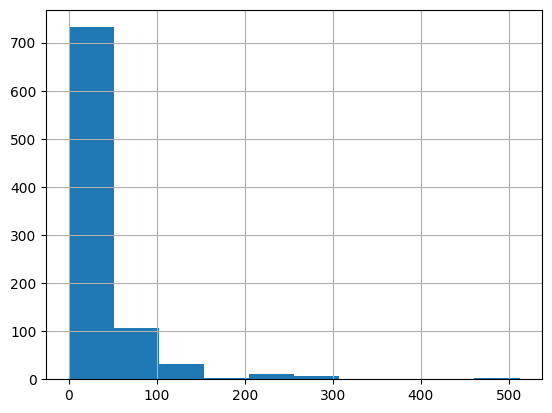

In [18]:
df['Fare'].hist()

In [19]:
# ^ This kind of situation in data is called "Long tail"

# Wikipedia: 
# In statistics and business, a long tail of some distributions of numbers 
# is the portion of the distribution having many occurrences far 
# from the "head" or central part of the distribution

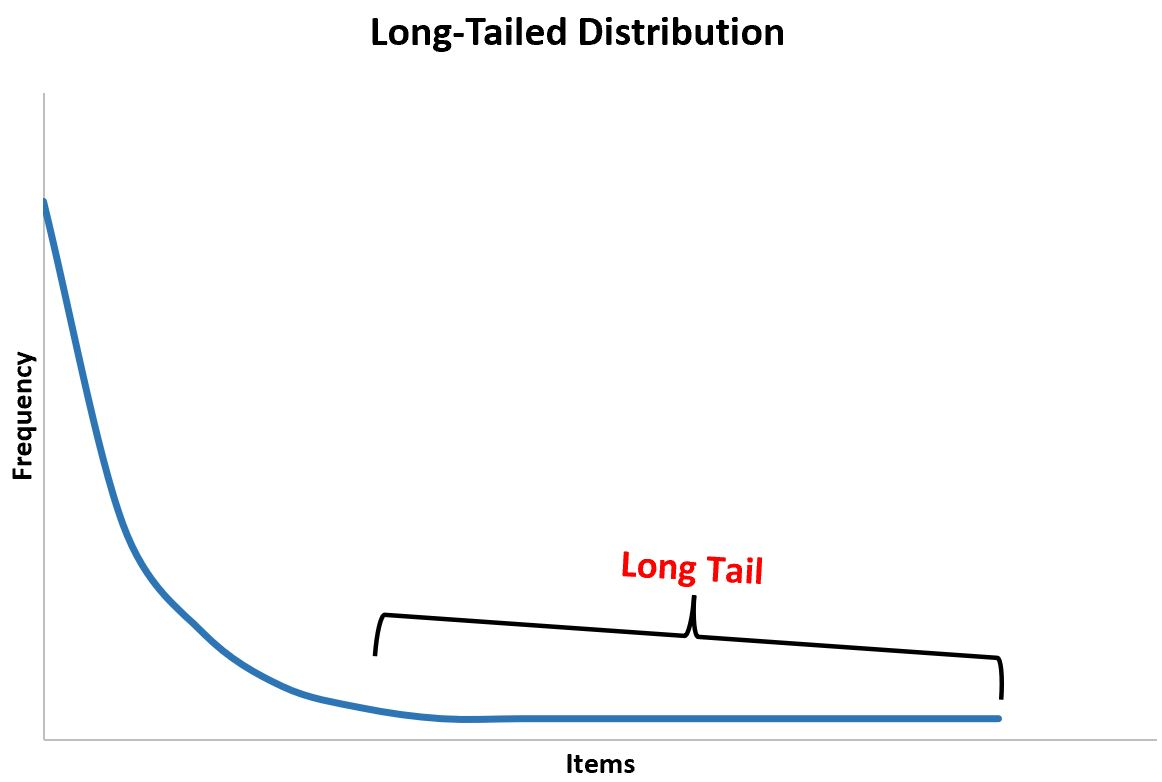
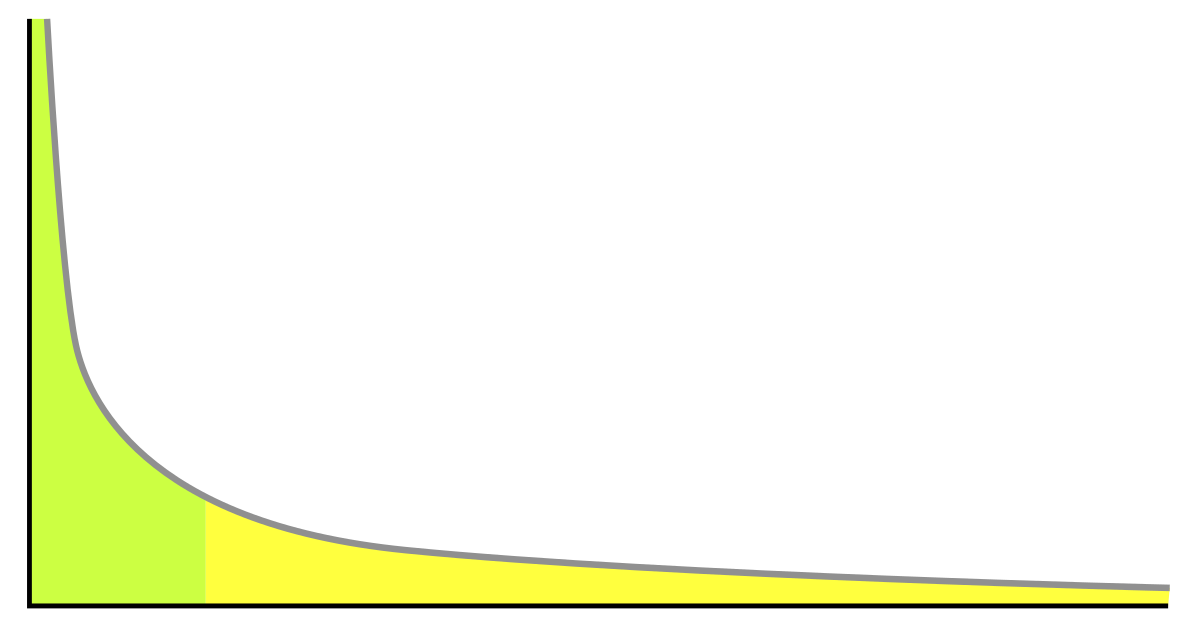

In [20]:
# Some models (linear, NN) "do not like" this kind of distribution,
# so we will use natural log on it to make it less tailed (?)

# log transform very big numbers into smaller one, and it change smol numbers much less
# TODO: (1) formulate it cleaner (2) why models doesnt like it?

In [21]:
df['LogFare'] = np.log(df['Fare']+1)

<Axes: >

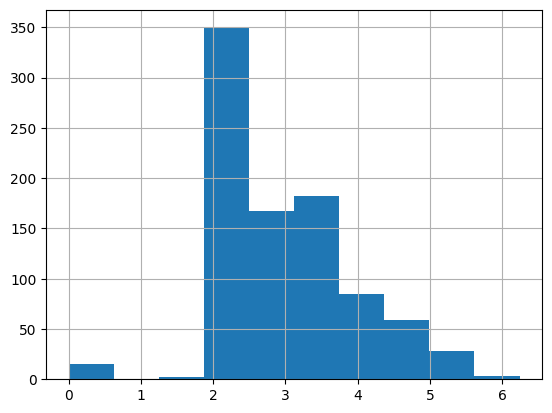

In [22]:
df['LogFare'].hist()

In [23]:
pclasses = sorted(df.Pclass.unique())
pclasses

[np.int64(1), np.int64(2), np.int64(3)]

In [24]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [170]:
# It should be done only once, since after `get_dummies` call
# specific columns will be REPLACED by dummie columns
if 'Sex' in df.columns:
    df = pd.get_dummies(df, columns=["Sex", "Pclass", "Embarked"])

assert 'Pclass_1' in df.columns, "Somehow we didn't get Pclass1 which is dummie column"
assert 'Pclass' not in df.columns, "Somehow Pclass column was not removed"

df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [171]:
added_cols = ["Sex_male", "Sex_female", "Pclass_1", "Pclass_2", "Pclass_3", 
              "Embarked_C", "Embarked_Q", "Embarked_S"]
independent_cols = ["Age", "SibSp", "Parch", "LogFare"] + added_cols

X = torch.tensor(df[independent_cols].astype(np.float32).values, dtype=torch.float32)
Y = torch.tensor(df.Survived)

X.shape, Y.shape

(torch.Size([891, 12]), torch.Size([891]))

In [172]:
# Let's "normalize" independent variables, since without that, our `Age`
# column will have tooooo much effect on optimization
print(f"Ages are: {X[:,0].tolist()[:3]} ...")
max_values, _ = X.max(dim=0)
X = X / max_values
print(f"Normalized ages are: {X[:,0].tolist()[:3]} ...")

Ages are: [22.0, 38.0, 26.0] ...
Normalized ages are: [0.2750000059604645, 0.4749999940395355, 0.32499998807907104] ...


In [173]:
torch.manual_seed(442)

n_weights = X.shape[1]
n_weights

12

In [174]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

In [175]:
X_tr, X_val = X[trn_split], X[val_split]
Y_tr, Y_val = Y[trn_split], Y[val_split]
len(X_tr), len(X_val)

(713, 178)

In [176]:
def calc_preds(weights, indeps):
    return torch.sigmoid(indeps@weights)

In [177]:
def calc_loss(weights, indeps, deps): 
    return torch.abs(calc_preds(weights, indeps)-deps).mean()

In [178]:
def init_weights():
    scaler = 0.1
    return (torch.rand(n_weights, 1)*scaler).requires_grad_()

In [179]:
def update_weights(weights, lr):
    weights.sub_(weights.grad * lr)
    weights.grad.zero_()

In [180]:
def one_epoch(weights, lr):
    loss = calc_loss(weights, X_tr, Y_tr)
    loss.backward()
    with torch.no_grad(): 
        update_weights(weights, lr)
    print(f"{loss:.3f}", end="; ")

In [181]:
def train_model(epochs=30, lr=2):
    torch.manual_seed(442)
    weights = init_weights()
    for i in range(epochs): 
        one_epoch(weights, lr=lr)
    return weights

In [182]:
def calculate_acc(weights, indeps, deps): 
    return (deps.bool()==(calc_preds(weights, indeps)>0.5)).float().mean()

In [183]:
# Turn dependent variables into matrices
Y_tr, Y_val = Y_tr[:, None], Y_val[:, None]

In [184]:
# weights = train_model(lr=100)

In [185]:
# calculate_acc(weights, X_tr, Y_tr)

In [186]:
# LAYERS TERRITORY

In [187]:
def init_weights(n_hidden=20):
    layer1 = (torch.rand(n_weights, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    # const aka bias (?)
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

In [188]:
import torch.nn.functional as F

def calc_preds(weights, indeps):
    l1,l2,const = weights
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [189]:
def update_weights(weights, lr):
    for layer in weights:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [190]:
# weights = train_model(lr=20)

In [191]:
# calculate_acc(weights, X_tr, Y_tr)

In [192]:
# DEEEP LEARNING

In [248]:
def init_weights():
    hiddens = [10, 10]  
    sizes = [n_weights] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [295]:
import torch.nn.functional as F

def calc_preds(weights, indeps):
    layers,consts = weights
    n = len(layers)
    # print(n)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1:
            res = F.relu(res)
    return torch.sigmoid(res)

In [296]:
def update_weights(weights, lr):
    layers,consts = weights
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [301]:
weights = train_model(lr=4)

0.521; 0.483; 0.427; 0.379; 0.379; 0.379; 0.379; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.377; 0.376; 0.371; 0.333; 0.239; 0.224; 0.208; 0.204; 0.203; 0.203; 0.207; 0.197; 0.196; 0.195; 

In [302]:
calculate_acc(weights, X_val, Y_val)

tensor(0.8258)